# Исследование показателей сервиса аренды самокатов

## Цель исследования

- Изучить основные показатели.
- Рассчитать выручку.

Проверить гипотезы:
- Тратят ли пользователи с подпиской больше времени на поездки?
- Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров (оптимальное расстояние с точки зрения износа самоката)? 
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Дополнительные задачи:
- Выяснить, снизилось ли количество обращений в техподдержку всвязи с обновлением серверов?
- Рассчитать минимальное количество промокодов, необходимое для продления подписки заданного числа клиентов.
- Рассчитать минимальное количество рассылки push-уведомлений, которые прочитает заданное число клиентов.

### Ход исследования

В качестве исходных данных используем информацию, предоставленную сервисом аренды самокатов в виде трёх таблиц в формате ".csv", описание таблиц приведем ниже.

Пользователи (users_go.csv):

- `user_id` - уникальный идентификатор пользователя;
- `name` - имя пользователя;
- `age` - возраст;
- `city` - город;
- `subscription_type` - тип подписки (free, ultra).

Поездки (rides_go.csv):

- `user_id` - уникальный идентификатор пользователя;
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах);
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
- `date` - дата совершения поездки.

Подписки (subscriptions_go.csv):

- `subscription_type` - тип подписки;
- `minute_price` - стоимость одной минуты поездки по данной подписке;
- `start_ride_price` - стоимость начала поездки;
- `subscription_fee` - стоимость ежемесячного платежа.

О качестве данных ничего не известно. Перед тем как приступить к исследованию, понадобится обзор данных и, при необходимости, предобработка.

Таким образом исследование имеет следующие этапы:
- Обзор данных.
- Предобработка данных.
- Исследование основных показателей.
- Объединение данных.
- Расчёт выручки.
- Проверка гипотез.
- Дополнительные задачи.
- Вывод.

## Обзор данных

### Получение данных

Загрузим данные из csv-файлов в датафреймы c помощью библиотеки pandas.

In [1]:
# импортируем необходимые модули
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
from math import factorial, sqrt
from matplotlib.pyplot import figure
import time
import warnings
import seaborn as sns

In [2]:
# создаем датафреймы из файлов .csv
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv')
subscriptions = pd.read_csv('subscriptions_go.csv')

### Общая информация

Выведем первые строки каждого датафрейма и получим общую информацию.

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


**Вывод:**

Пропусков нет. Данные имеют корректную структуру.

In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


**Вывод:**

Пропусков нет. Необходимо привести столбец `date` к типу даты pandas.

In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:**

Пропусков нет. Данные имеют корректную структуру.

## Предобработка данных

### Изменение типов данных

In [9]:
# в датафрейме rides приведем столбец 'date' к типу даты pandas.
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [10]:
# выведем первые строки таблицы
rides.head(3)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20


In [11]:
# получим общую информацию о данных
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


**Вывод:**

Тип данных изменен.

### Проверка на пропуски и дубликаты

**Выполним проверку для датафрейма `users`.**

In [12]:
# Число пропусков
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропусков не обнаружено.

In [13]:
# Число явных дубликатов
users.duplicated().sum()

31

In [14]:
# Дубликаты в столбце 'user_id'
users['user_id'].duplicated().sum()

31

Обнаружены явные дубликаты. Удалим их.

In [15]:
# удаление явных дубликатов
users = users.drop_duplicates().reset_index(drop=True)

# Число явных дубликатов после удаленя
users.duplicated().sum()

0

Явные дубликаты удалены. Проверим, есть ли неявные.

In [16]:
# выведем первые строки
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [17]:
# уникальные значения в столбце 'city'
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [18]:
# уникальные значения в столбце 'subscription_type'
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

Неявных дубликатов не обнаружено.

**Выполним проверку для датафрейма `rides`.**

In [19]:
# Число пропусков
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

Пропусков не обнаружено.

In [20]:
# Число явных дубликатов
rides.duplicated().sum()

0

Явных дубликатов не обнаружено.

**Выполним проверку для датафрейма `subscriptions`.**

In [21]:
# Число пропусков
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков не обнаружено.

In [22]:
# Число явных дубликатов
subscriptions.duplicated().sum()

0

Явных дубликатов не обнаружено. Проверим наличие неявных дубликатов.

In [23]:
# уникальные значения в столбце 'subscription_type'
subscriptions['subscription_type'].value_counts()

free     1
ultra    1
Name: subscription_type, dtype: int64

Неявных дубликатов не обнаружено.

**Вывод:**

Пропусков не обнаружено. Дубликаты удалены.

### Создание нового столбца

Создадим новый столбец с номером месяца на основе столбца `'date'`.

In [24]:
# проверим за какой период имеются данные
print('Данные имеются за период:')
print(rides['date'].min().date(), '-', rides['date'].max().date())

Данные имеются за период:
2021-01-01 - 2021-12-30


Данные имеются за 1 календарный год. Создадим столбец с номерами месяцев от 1 до 12.

In [25]:
# создаем столбец
rides['month'] = rides['date'].dt.month.astype('Int64')

In [26]:
# для проверки выведем первые строки таблицы
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**Вывод:**

Создан новый столбец `'month'`.

## Исследование основных показателей

Исследуем следующие параметры:
- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

### Частота встречаемости городов

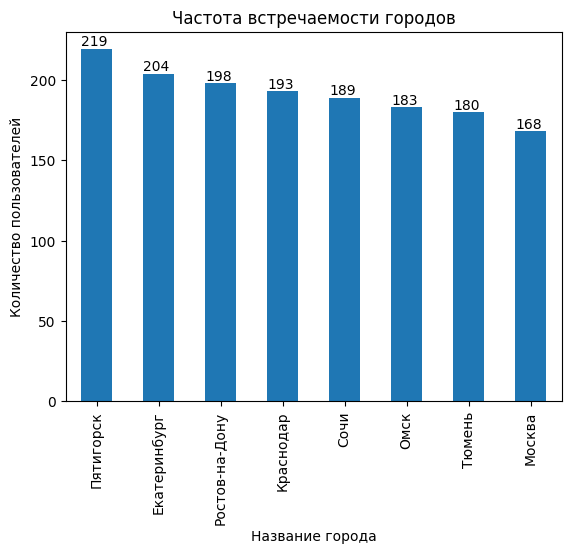

In [27]:
# построим диаграмму 
ax=users['city'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1.01))
plt.title('Частота встречаемости городов')
plt.ylabel('Количество пользователей')
plt.xlabel('Название города')

plt.show()

**Вывод:**

В таблице `users` наибольшее число пользователей из Пятигорска и наименьшее из Москвы.

### Cоотношение пользователей с подпиской и без подписки

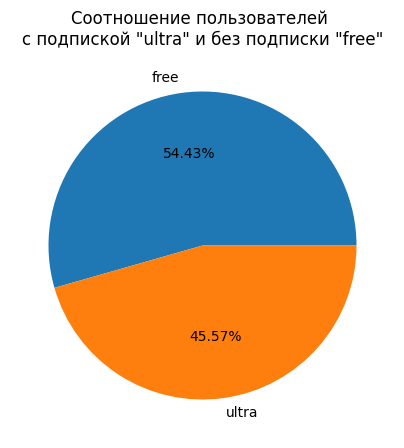

In [28]:
# построим круговую диаграмму 
users['subscription_type'].value_counts().plot(
    kind='pie', 
    autopct='%.2f%%'
) 
plt.title('Соотношение пользователей \nс подпиской "ultra" и без подписки "free"')
plt.ylabel('')
fig = plt.gcf()
fig.set_size_inches(5,5) 

plt.show()

**Вывод:**

Пользователей без подписки больше на 8,86 %.

### Возраст пользователей

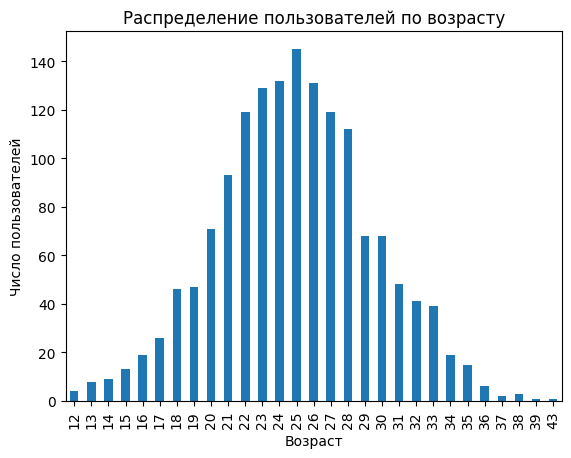

In [29]:
# построим гистограмму
(users['age']
 .value_counts()
 .sort_index()
 .plot(kind='bar'))

plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Число пользователей')

plt.show()

In [30]:
# получим общую информацию о столбце
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

**Вывод:**

Средний возраст пользователей 25 лет. Минимальный возраст 12 лет, максимальный - 43 года. 

### Расстояние, которое пользователь преодолел за одну поездку

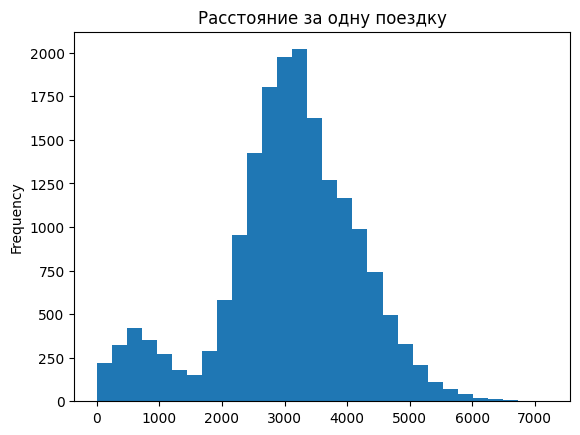

In [31]:
# построим гистограмму
rides['distance'].plot(kind='hist', 
                       bins=30, 
                       title = 'Расстояние за одну поездку')
plt.show()

In [32]:
# получим общую информацию о столбце
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

**Вывод:**

Медианное расстояние 3134 м., что близко к оптимальному расстоянию с точки зрения износа самоката - 3130 м. 

На графике заметен пик с вершиной при расстоянии в районе полукилометра. Это может отображать, что пользователи меняют самокат на другой. Например, если возле дома был самокат с низким уровнем заряда или с неполадками (м.б. плохо работающими тормозами), можно доехать до другой ближайшей стоянки и сменить его. Данная гипотеза требует отдельной проверки.

### Продолжительность поездок

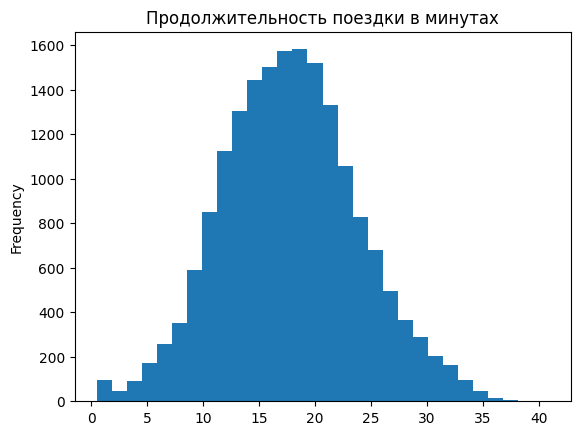

In [33]:
# построим гистограмму
rides['duration'].plot(kind='hist', 
                       bins=30, 
                       title = 'Продолжительность поездки в минутах')
plt.show()

In [34]:
# получим общую информацию о столбце
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

**Вывод:**

Медианная длительность поездки 18 минут. Самая длительная поездка - 41 минута. Более половины всех поездок в диапазоне от 13 до 22 минут.

## Объединение данных

Создадим 3 датафрейма:
- `df_all` - данные о пользователях, поездках и подписках;
- `df_free` - на основе `df_all`, пользователи без подписки;
- `df_ultra` - на основе `df_all`, пользователи с подпиской.

In [35]:
# объединяем датафреймы в один df_all
df_all = users.merge(
    subscriptions,
    on='subscription_type', # название столбца, по которому объединять
    how='inner', # режим объединения
    )
df_all = df_all.merge(
    rides,
    on='user_id', # название столбца, по которому объединять
    how='inner', # режим объединения
    )

In [36]:
# Добавим в датафрейм df_all столбец 'is_subscription' с информацией о типе подписки в формате:
# False - нет подписки, True - есть подписка.

def categorize(row):
    if 'ultra' in row:
        return True
    elif 'free' in row:
        return False

df_all['is_subscription'] = df_all['subscription_type'].apply(categorize).astype('bool')

# выведем первые строки df_all
df_all.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,is_subscription
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1,True
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1,True
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4,True
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8,True
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8,True


In [37]:
# Получим информацию о новом датафрейме
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   minute_price       18068 non-null  int64         
 6   start_ride_price   18068 non-null  int64         
 7   subscription_fee   18068 non-null  int64         
 8   distance           18068 non-null  float64       
 9   duration           18068 non-null  float64       
 10  date               18068 non-null  datetime64[ns]
 11  month              18068 non-null  Int64         
 12  is_subscription    18068 non-null  bool          
dtypes: Int64(1), bool(1), datetime64[ns](1), float64(2), int64(5)

In [38]:
# выведем размеры исходных таблиц для срерки с результирующей
print(f'размеры исходных таблиц\nusers: {users.shape}\nrides: {rides.shape}\nsubscriptions: {subscriptions.shape}')

размеры исходных таблиц
users: (1534, 5)
rides: (18068, 5)
subscriptions: (2, 4)


Количество строк: 18068 - совпадает, количество столбцов: 5 + 5 + 4 - 2 (по которым объединяли) + 1 (новый) = 13 - верно.

In [39]:
# Сверим количество записей "ultra" с количеством "True" в новом столбце 
print(df_all.query('subscription_type == "ultra"')['subscription_type'].count()) 
print(df_all.query('is_subscription == True')['is_subscription'].count())

6500
6500


Количество записей "ultra" совпадает с количеством "True" в новом столбце `'is_subscription'`.

In [40]:
# проверим новый датафрейм на пропуски
df_all.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
distance             0
duration             0
date                 0
month                0
is_subscription      0
dtype: int64

Пропусков не обнаружено.

**Вывод:**

Новый датафрейм `df_all` создан. Объединение данных прошло корректно. Добавлен новый столбец `is_subscription`.

In [41]:
# создаем датафрейм df_free (пользователи без подписки)
df_free = df_all.query('subscription_type == "free"')

# выведем первые строки
df_free.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,is_subscription
6500,700,Айдар,22,Омск,free,8,50,0,2515.690719,14.944286,2021-01-02,1,False
6501,700,Айдар,22,Омск,free,8,50,0,846.932642,16.234663,2021-02-01,2,False
6502,700,Айдар,22,Омск,free,8,50,0,4004.434142,20.016628,2021-02-04,2,False
6503,700,Айдар,22,Омск,free,8,50,0,1205.911290,9.782872,2021-02-10,2,False
6504,700,Айдар,22,Омск,free,8,50,0,3047.379435,17.427673,2021-02-14,2,False


In [42]:
# размеры датафрейма
df_free.shape

(11568, 13)

In [43]:
# создаем датафрейм df_ultra (пользователи с подпиской)
df_ultra = df_all.query('subscription_type == "ultra"')

# выведем первые строки
df_ultra.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,is_subscription
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1,True
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1,True
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4,True
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8,True
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8,True


In [44]:
# размеры датафрейма
df_ultra.shape

(6500, 13)

In [45]:
# сверим количесво строк и столбцов в трех датафреймах
(df_ultra.shape[0] + df_free.shape[0] == df_all.shape[0] and
 df_all.shape[1] == df_ultra.shape[1] and
 df_all.shape[1] == df_free.shape[1])

True

**Вывод:**

Новые датафреймы `df_free` и `df_ultra` созданы. 

### Расстояние и время поездки для пользователей с подпиской и без подписки

Используя объединенные данные визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий подписки.

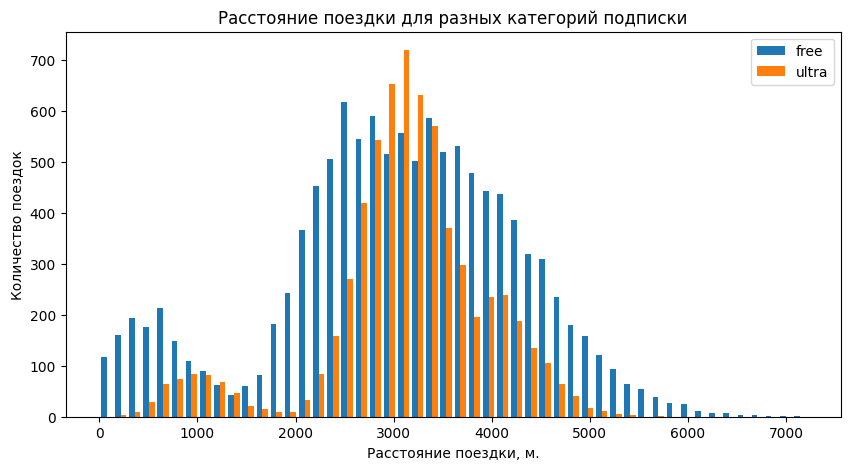

In [46]:
# построим гистограмму 
plt.hist([df_free['distance'], df_ultra['distance']], 50, label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('Расстояние поездки для разных категорий подписки')
plt.xlabel('Расстояние поездки, м.')
plt.ylabel('Количество поездок')
fig = plt.gcf()
fig.set_size_inches(10,5) 
plt.show()

In [47]:
# выведем информацию по столбцу 'distance' для пользователей без подписки
df_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [48]:
# выведем информацию по столбцу 'distance' для пользователей с подпиской
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

**Вывод:**

Пользователи с подпиской всреднем ездят на более длинные дистанции: 3315 м., у пользователей без подписки этот показатель составляет 3045 м. При этом стандартное отклонение расстояния поездки у пользователей с подпиской гораздо ниже. Это может означать, что пользователи берут подписку с определенной целью, например, чтобы добираться на самокате до работы, поэтому расстояние изо дня в день меняется не так сильно. 

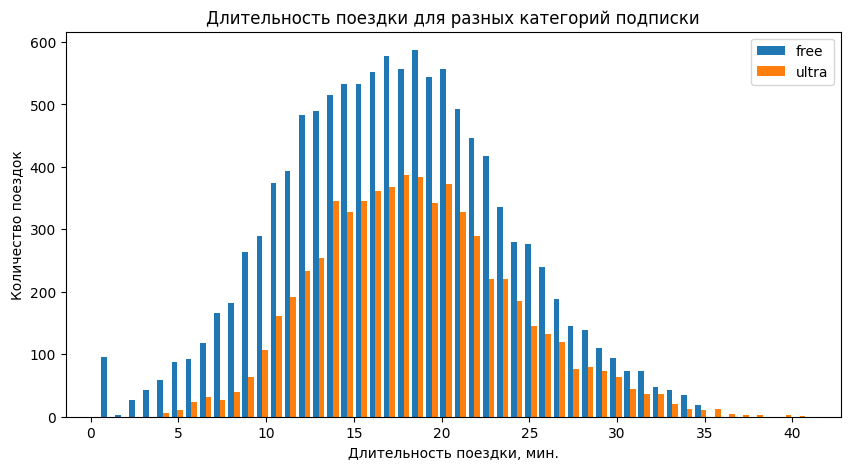

In [49]:
# построим гистограмму 
plt.hist([df_free['duration'], df_ultra['duration']], 50, label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('Длительность поездки для разных категорий подписки')
plt.xlabel('Длительность поездки, мин.')
plt.ylabel('Количество поездок')
fig = plt.gcf()
fig.set_size_inches(10,5) 
plt.show()

In [50]:
# выведем информацию по столбцу 'duration' для пользователей без подписки
df_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [51]:
# выведем информацию по столбцу 'duration' для пользователей с подпиской
df_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

**Вывод:**

Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки (18,5 мин. и 17,4 мин. соответственно). При этом, как и в случае с расстоянием, стандартное отклонение времени поездки у пользователей с подпиской ниже.

### Расчёт выручки

Для расчёта выручки произведем следующие шаги:
1. Создадим датафрейм `df_revenue` с агрегированными данными на основе `df_all` для каждого пользователя за каждый месяц со следующими параметрами:
- суммарное расстояние; 
- количество поездок; 
- суммарное время.

Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округлим вверх до следующего целого числа.

Для расчёта выручки добавим дополнительные столбцы:
- стоимость старта;
- стоимость 1 минуты;
- стоимость подписки.

2. В полученный датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

Помесячная выручка = стоимость старта поездки *  количество поездок + стоимость одной минуты поездки * общая продолжительность всех поездок в минутах + стоимость подписки.




In [52]:
# округляем столбец 'duration' вверх до целого числа
df_all['duration'] = np.ceil(df_all['duration'])

In [53]:
# выведем первые строки, проверим округление
df_all.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,is_subscription
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,26.0,2021-01-01,1,True
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,16.0,2021-01-18,1,True
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,7.0,2021-04-20,4,True
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,19.0,2021-08-11,8,True
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,27.0,2021-08-28,8,True


In [54]:
# проверка количества строк
df_all.shape

(18068, 13)

In [55]:
# проверка пропусков
df_all.isna().sum().sum()

0

Округление данных прошло успешно.

In [56]:
# создаем датафрейм - сводную таблицу
df_revenue = df_all.pivot_table(
    index = ['user_id', 'month'],  
    values = ['distance', 
              'duration',
              'date',
              'start_ride_price',
              'minute_price',
              'subscription_fee',
              'is_subscription',
             ],
    aggfunc = {'distance' : ['sum', 'count'], 
               'duration' : 'sum',
               'start_ride_price' : 'mean',
               'minute_price' : 'mean',
               'subscription_fee' : 'mean',
               'is_subscription' : 'mean',
              })

# объединяем двухуровневые названия столбцов в одну строку через '_'
df_revenue.columns = list(map("_".join, df_revenue.columns))

# выведем первые строки полученной таблицы
df_revenue.head(10)

distance_count  distance_sum  duration_sum  \
user_id month                                               
1       1                   2   7027.511294          42.0   
        4                   1    754.159807           7.0   
        8                   2   6723.470560          46.0   
        10                  2   5809.911100          32.0   
        11                  3   7003.499363          56.0   
        12                  2   6751.629942          28.0   
2       3                   3  10187.723006          63.0   
        4                   2   6164.381824          40.0   
        6                   1   3255.338202          14.0   
        7                   2   6780.722964          48.0   

               is_subscription_mean  minute_price_mean  start_ride_price_mean  \
user_id month                                                                   
1       1                       1.0                6.0                    0.0   
        4                       1.0                6.0                    0.0   
        8                       1.0                6.0                    0.0   
        10                      1.0                6.0                    0.0   
        11                      1.0                6.0                    0.0   
        12                      1.0                6.0                    0.0   
2       3                       1.0                6.0                    0.0   
        4                       1.0                6.0                    0.0   
        6                       1.0                6.0                    0.0   
        7                       1.0                6.0                    0.0   

               subscription_fee_mean  
user_id month                         
1       1                      199.0  
        4                      199.0  
        8                      199.0  
        10                     199.0  
        11                     199.0  
        12                     199.0  
2       3                      199.0  
        4                      199.0  
        6                      199.0  
        7                      199.0

In [57]:
# проверим корректность столбца 'is_subscription_mean'
df_revenue.query('is_subscription_mean == False').head(10)

distance_count  distance_sum  duration_sum  \
user_id month                                               
700     1                   1   2515.690719          15.0   
        2                   5  13446.659764          89.0   
        3                   1   3798.334905          19.0   
        4                   1   2984.551206          16.0   
        6                   2   5927.650988          29.0   
        7                   2   4399.206279          21.0   
        8                   1   4071.654669          17.0   
        10                  2   6322.578618          44.0   
        11                  3   8735.782625          32.0   
701     1                   1   2676.472894          18.0   

               is_subscription_mean  minute_price_mean  start_ride_price_mean  \
user_id month                                                                   
700     1                       0.0                8.0                   50.0   
        2                       0.0                8.0                   50.0   
        3                       0.0                8.0                   50.0   
        4                       0.0                8.0                   50.0   
        6                       0.0                8.0                   50.0   
        7                       0.0                8.0                   50.0   
        8                       0.0                8.0                   50.0   
        10                      0.0                8.0                   50.0   
        11                      0.0                8.0                   50.0   
701     1                       0.0                8.0                   50.0   

               subscription_fee_mean  
user_id month                         
700     1                        0.0  
        2                        0.0  
        3                        0.0  
        4                        0.0  
        6                        0.0  
        7                        0.0  
        8                        0.0  
        10                       0.0  
        11                       0.0  
701     1                        0.0

Значения "False" также присутствуют в таблице. Верно.

In [58]:
# проверим сводную таблицу на ниличие пропусков
df_revenue.isna().sum()

distance_count           0
distance_sum             0
duration_sum             0
is_subscription_mean     0
minute_price_mean        0
start_ride_price_mean    0
subscription_fee_mean    0
dtype: int64

Пропусков не обнаружено.

Сводная таблица создана. Пропусков и ошибок не обнаружено. Приступим к подсчёту выручки.

In [59]:
# добавляем столбец с выручкой
df_revenue['revenue'] = (
    # цена старта * кол. поездок
    (df_revenue['start_ride_price_mean'] * df_revenue['distance_count']) 
    +
    # цена минуты * кол. минут
    (df_revenue['minute_price_mean'] * df_revenue['duration_sum'])
    +
    # стоимость подписки
    df_revenue['subscription_fee_mean']
)

# выведем первые строки
df_revenue.head(10)

distance_count  distance_sum  duration_sum  \
user_id month                                               
1       1                   2   7027.511294          42.0   
        4                   1    754.159807           7.0   
        8                   2   6723.470560          46.0   
        10                  2   5809.911100          32.0   
        11                  3   7003.499363          56.0   
        12                  2   6751.629942          28.0   
2       3                   3  10187.723006          63.0   
        4                   2   6164.381824          40.0   
        6                   1   3255.338202          14.0   
        7                   2   6780.722964          48.0   

               is_subscription_mean  minute_price_mean  start_ride_price_mean  \
user_id month                                                                   
1       1                       1.0                6.0                    0.0   
        4                       1.0                6.0                    0.0   
        8                       1.0                6.0                    0.0   
        10                      1.0                6.0                    0.0   
        11                      1.0                6.0                    0.0   
        12                      1.0                6.0                    0.0   
2       3                       1.0                6.0                    0.0   
        4                       1.0                6.0                    0.0   
        6                       1.0                6.0                    0.0   
        7                       1.0                6.0                    0.0   

               subscription_fee_mean  revenue  
user_id month                                  
1       1                      199.0    451.0  
        4                      199.0    241.0  
        8                      199.0    475.0  
        10                     199.0    391.0  
        11                     199.0    535.0  
        12                     199.0    367.0  
2       3                      199.0    577.0  
        4                      199.0    439.0  
        6                      199.0    283.0  
        7                      199.0    487.0

In [60]:
# средняя выручка по месяцам от каждого пользователя.
print('Средняя помесячная выручка от всех пользователей:', df_revenue['revenue'].mean().round(2))
print('Средняя помесячная выручка от пользователей без подписки:', df_revenue.query('is_subscription_mean == False')['revenue'].mean().round(2))
print('Средняя помесячная выручка от пользователей с подпиской:', df_revenue.query('is_subscription_mean == True')['revenue'].mean().round(2))

Средняя помесячная выручка от всех пользователей: 342.3
Средняя помесячная выручка от пользователей без подписки: 328.64
Средняя помесячная выручка от пользователей с подпиской: 362.79


**Вывод:**

Расчитали выручку от каждого пользователя по месяцам. 

Средняя помесячная выручка от пользователей: 
- общая: 342,3 руб./мес.;
- без подписки: 328.64 руб./мес.;
- с подпиской: 362.79 руб./мес..

## Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки?

Для проверки гипотезы выполним T-тест.

- Нулевая гипотеза: пользователи с подпиской и пользователи без подписки всреднем тратят одинаковое количество времени на поездки.
- Альтернативная гипотеза: среднее время поездки пользователей с подпиской больше, чем среднее время поездки пользователей без подписки

Чтобы проверить такую гипотезу, нужно передать в метод `ttest_ind()` сначала выборку с продолжительностью поездки пользователей с подпиской `df_ultra['duration']`, затем выборку с продолжительностью поездки пользователей без подписки `df_free['duration']`. В качестве alternative нужно указать 'greater', то есть «больше».

In [61]:
# задаём уровень значимости
alpha = 0.05

# время поездки первой группы пользователей (с подпиской)
first_group = df_ultra['duration']

# время поездки второй группы пользователей (без подписки)
second_group = df_free['duration']

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(first_group, second_group, alternative='greater')

print(f'p-значение: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


**Вывод:**

Полученное значение p-значение: 1.2804098316645618e-34 меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания утверждать, что пользователи с подпиской тратят больше времени на поездки.

### Расстояние, которое проезжают пользователи с подпиской не превышает 3130 метров?

Для проверки гипотезы выполним T-тест. Гипотеза является односторонней. 

- Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской не превышает 3130 метров
- Альтернативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской больше 3130 метров

Чтобы проверить такую гипотезу, нужно передать в метод `ttest_1samp()` сначала выборку с расстоянием поездок пользователей с подпиской `df_ultra['distance']`, затем интересующее значение 3130 м. В качестве alternative нужно указать 'greater', то есть «больше».

In [62]:
distance = df_ultra['distance']

target_distance = 3130 # предельное расстояние поездки для оптимального износа

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(distance, target_distance, alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу: расстояние значимо больше {target_distance} м.')
else:
    print(f'Не получилось отвергнуть нулевую гипотезу: расстояние не превышает {target_distance} м.')   

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу: расстояние не превышает 3130 м.


**Вывод:**

Полученное p-значение больше заданного уровня значимости, поэтому не отвергаем нулевую гипотезу. 

Есть основания говорить, что среднее расстояние, которое проезжают пользователи с подпиской не превышает 3130 метров.

### Помесячная выручка от пользователей с подпиской выше, чем без подписки?

Для проверки гипотезы выполним T-тест.

- Нулевая гипотеза: средняя помесячная выручка от пользователей с подпиской и от пользователей без подписки одинакова.
- Альтернативная гипотеза: средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

Чтобы проверить такую гипотезу, нужно передать в метод `ttest_ind()` сначала выборку с помесячной выручкой от пользователей с подпиской `df_revenue.query('subscription_fee_mean != 0')['revenue']`, затем выборку с помесячной выручкой от пользователей без подписки `df_revenue.query('subscription_fee_mean == 0')['revenue']`. В качестве alternative нужно указать 'greater', то есть «больше».

In [63]:
# задаём уровень значимости
alpha = 0.05

# время поездки первой группы пользователей (с подпиской)
first_group = df_revenue.query('subscription_fee_mean != 0')['revenue']

# время поездки второй группы пользователей (без подписки)
second_group = df_revenue.query('subscription_fee_mean == 0')['revenue']

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(first_group, second_group, alternative='greater')

print(f'p-значение: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Вывод:**

Полученное p-значение меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания утверждать, что средняя помесячная выручка от пользователей с подпиской выше, чем без подписки.

## Дополнительные задачи

###  Снизилось ли количество обращений в техподдержку всвязи с обновлением серверов?

Данные для проверки гипотезы не были предоставлены, однако известно, что некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. 

**Рекомендация:**

Для решения этой задачи нужно проверить одностороннюю гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок. Для расчёта в Python можно применить метод `scipy.stats.ttest_rel()`.

### Количество промокодов, необходимых для продления подписки заданного количества клиентов.

Нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. 

Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Для решения используем биномиальное распределение, которое описывает указанную ситуацию. Затем подберем подходящее значение параметра `n` для заданного параметра `p=0.1` с помощью графиков и метода `cdf()`.

Минимальное число промокодов: 1161
Для подписки 100 клиентов
c вероятностью успеха: 95.02 %


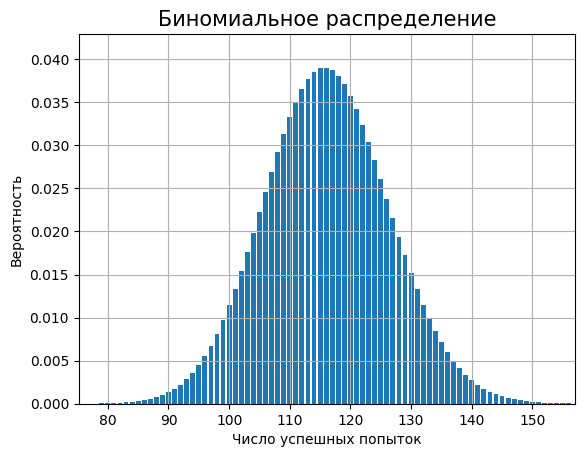

In [64]:
n = 1 # количество попыток, искомая величина, 1 - начальное значение.
p = 0.1 # вероятность успеха
alpha = 0.05 # уровень статистической значимости
success_target = 99 # целевое число успехов

timeout = time.time() + 10 # остановим цикл, если за отведенное время решение не найдется
warnings.filterwarnings("ignore", category=RuntimeWarning) # отключаем оповещения, поскольку timeout мы выставили 

# Увеличиваем число попыток, пока вероятность неудачи не станет меньше alpha
while binom.cdf(success_target, n, p, loc=0) > alpha:
    if time.time() > timeout:
        break
    n += 1
else: 
    print('Минимальное число промокодов:', n)  
    print(f'Для подписки {success_target + 1} клиентов')
    print(f'c вероятностью успеха: {round((1-binom.cdf(success_target, n, p, loc=0))*100,2)} %')

# cтроим диаграмму  
distr = [] # в этом списке храним значения распределения

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr) # строим столбчатую диаграмму
plt.title('Биномиальное распределение', fontsize=15) # заголовок
plt.xlabel('Число успешных попыток') # подпись оси х
plt.ylabel('Вероятность') # подпись оси у
plt.grid(True) # оси

expect = n * p # мат. ожидание
std = binom.std(n, p, loc=0) # стандартное отклонение
k_ = int(expect) # возьмем за число успехов мат. ожидание (для масштаба графика)
prob = binom.pmf(k_, n, p, loc=0) # найдем вероятность k-успешных попыток

# автоматически масштабируем график, обрезаем по х и по y
plt.axis([expect - 4 * std, expect + 4 * std, 0, 1.1 * prob]) 

plt.show()
warnings.filterwarnings("default", category=RuntimeWarning) # снова включаем оповещения

**Вывод:**

Необходимо разослать минимум 1161 промокод для подписки 100 клиентов, при таком количестве вероятность успеха составляет более 95%.

### Количество push-уведомлений, которые прочитает заданное число клиентов.

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. 

Необходимо:
1. Построить примерный график распределения (с помощью аппроксимации).
2. Оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Возьмем промежуток от математического ожидания биномиального распределения плюс-минус три его стандартных отклонения. Если он лежит в пределах `[0,n]`(то есть там, где биномиальное распределение определено), то его форма будет симметрична и близка к нормальному распределению, тогда аппроксимируем биномиальное распределение нормальным.

Условие аппроксимации выполняется
Вероятность, что уведомление откроют не более 399500 чел.: 15.37 %


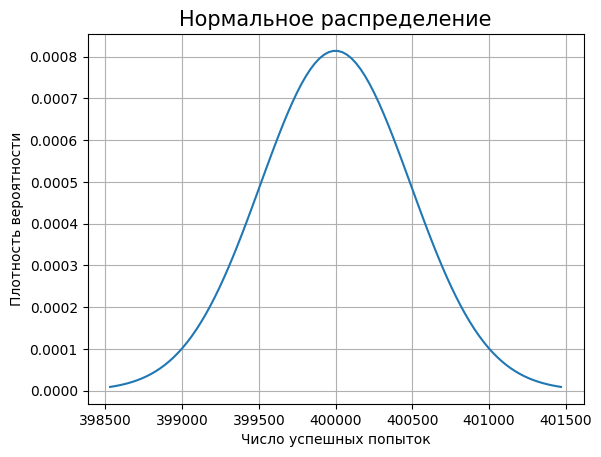

In [65]:
# задаём параметры биномиального распределения
n = 1000000 # количество попыток
p = 0.4 # вероятность успеха
target = 399500 # целевое число успехов (максимальное)

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
expect = n * p
std = sqrt(n * p * (1 - p))

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли expect ± 3 std в промежутке от 0 до n:
if (expect - (3 * std) >= 0) and ((expect + (3 * std) <= n)):
    print('Условие аппроксимации выполняется')
else:
    print('Условие аппроксимации не выполняется')

# задаём нормальное распределение
distr = st.norm(expect, std) 

# считаем вероятность хвоста слева от числа успехов
result = distr.cdf(target)
print(f'Вероятность, что уведомление откроют не более {target} чел.: {round(result*100,2)} %')

x = np.linspace(expect - 3 * std, expect + 3 * std, 100)
plt.plot(x, st.norm.pdf(x, expect, std))
plt.title('Нормальное распределение', fontsize=15) # заголовок
plt.xlabel('Число успешных попыток') # подпись оси х
plt.ylabel('Плотность вероятности') # подпись оси у
plt.grid(True) # оси

plt.show()

**Вывод:**

Биномиальное распределение аппроксимировали нормальным и построили график. Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равна 15,37%.

## Вывод

**Вывод:**

В ходе исследования мы провли следующую работу:
- изучили данные, проверили их на предмет аномалий и несоответствий;
- подготовили данные для анализа: удалили дубликаты, изменили тип данных в столбце, добавили новый столбец;
- исследовали основные параметры сервиса аренды самокатов: распределение пользователей по городам и возрасту, расстояние и продолжительность поездок, тип подписки;
- объединили данные и рассчитали: помесячную выручку, расстояние и время поездки по типам подписки;
- проверили три гипотезы;
- решили две дополнительные задачи и дали рекомендацию по решению третьей.

В ходе исследования установили следующее:
- в предоставленных данных чаще всего встречаются пользователи из Пятигорска, реже - из Москвы;
- пользователей без подписки: 54,43 %;
- средний  возраст пользователей: 25 лет;
- медианное растояние за одну поездку: 3134 м;
- медианная длительность поездки: 18 минут.;
- пользователи с подпиской ездят на более длинные дистанции;
- средняя помесячная выручка от пользователей: 
-- общая: 342,3 руб./мес.;
-- без подписки: 328.64 руб./мес.;
-- с подпиской: 362.79 руб./мес..

В ходе проверки гипотез появились основания утверждать следующее:
- пользователи с подпиской всреднем тратят больше времени на поездки;
- среднее расстояние, которое проезжают пользователи с подпиской не превышает 3130 метров;
- средняя помесячная выручка от пользователей с подпиской выше, чем без подписки.

Принимая в учёт, что пользователи с подпиской приносят бóльшую выручку, а среднее расстояние их поездки не превышает оптимального с точки зрения износа самоката, можно сделать вывод, что пользователи с подпиской выгоднее для сервиса.

Решили дополнительные задачи и получили следующие результаты:
- необходимо разослать минимум 1161 промокод для подписки 100 клиентов, при таком количестве вероятность успеха составляет более 95%;
- при рассылке 1 млн. push-уведомлений вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равна 15,37%.

Рекомендация для проверки снизилось ли количество обращений в техподдержку всвязи с обновлением серверов:
- для ответа на этот вопрос нужно проверить одностороннюю гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок. Для расчёта в Python можно применить метод `scipy.stats.ttest_rel()`.